##### Import Libraries.

In [ ]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
import tensorflow as tf

###### Download Datasets

In [ ]:
!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6

Downloading...
From (original): https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
From (redirected): https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6&confirm=t&uuid=c735a1c3-843f-4447-a6af-24a8ad734433
To: /content/lol_dataset.zip
100% 347M/347M [00:05<00:00, 61.0MB/s]


##### Unzip dataset Files

In [ ]:
!unzip -q lol_dataset.zip

#### Creating Dataset

In [ ]:
random.seed(10)

IMAGE_SIZE = 64
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 400


In [ ]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image

In [ ]:
def random_crop(low_res_image, enhanced_image):
    low_image_shape = tf.shape(low_res_image)[:2]
    low_w = tf.random.uniform(shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32)
    low_h = tf.random.uniform(shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32)
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_res_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


In [ ]:
def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image

In [ ]:
def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [ ]:
train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/eval15/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>


##### MIRNet Model
 Selective Kernel Feature Fusion

In [ ]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = layers.Reshape((1, 1, channels))(gap)
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

Dual Attention Unit

In [ ]:
class ChannelPooling(layers.Layer):
    def __init__(self, axis=-1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config


def spatial_attention_block(input_tensor):
    compressed_feature_map = ChannelPooling(axis=-1)(input_tensor)
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(compressed_feature_map)
    feature_map = keras.activations.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = layers.Reshape((1, 1, channels))(average_pooling)
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

Multi-Scale Residual Block

In [ ]:
def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau),
        level2_dau,
        up_sampling_module(level3_dau),
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])

MIRNet Model

In [ ]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=32)

In [ ]:
# Enable mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

print('Mixed precision enabled')
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Mixed precision enabled
Compute dtype: float16
Variable dtype: float32


In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import mixed_precision

# ✅ Enable mixed precision (float16 for speed, float32 for stability where needed)
mixed_precision.set_global_policy('mixed_float16')

num_epochs = 50 # Reduced the number of epochs

lr = 1e-4

# Loss function
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

# Metric
def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

# ✅ Wrap optimizer with LossScaleOptimizer for float16 stability
base_optimizer = keras.optimizers.Adam(learning_rate=lr)
optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)

# Callbacks
tb_callback = keras.callbacks.TensorBoard(
    log_dir="./logs/ReduceLROnPlateau", histogram_freq=1
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_peak_signal_noise_ratio",
    patience=10,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=charbonnier_loss,
    metrics=[peak_signal_noise_ratio]
)

# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        ),
        early_stopping,
        tb_callback,
    ],
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/tensorboard.py:680: UserWarning: Model failed to serialize as JSON. Ignoring... The `get_config()` method of <ChannelPooling name=channel_pooling, built=True> should return a dict. It returned: None
  warnings.warn(f"Model failed to serialize as JSON. Ignoring... {exc}")


100/100 ━━━━━━━━━━━━━━━━━━━━ 417s 649ms/step - loss: 0.2459 - peak_signal_noise_ratio: 60.8585 - val_loss: 0.1837 - val_peak_signal_noise_ratio: 62.8442 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - loss: 0.1611 - peak_signal_noise_ratio: 63.8768 - val_loss: 0.1560 - val_peak_signal_noise_ratio: 64.2556 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - loss: 0.1667 - peak_signal_noise_ratio: 63.7024 - val_loss: 0.1379 - val_peak_signal_noise_ratio: 65.1174 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - loss: 0.1533 - peak_signal_noise_ratio: 64.3247 - val_loss: 0.1546 - val_peak_signal_noise_ratio: 64.7538 - learning_rate: 1.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 313ms/step - loss: 0.1538 - peak_signal_noise_ratio: 64.3648 - val_loss: 0.1617 - val_peak_signal_noise_ratio: 64.6190 - learning_rate: 1.0000e-04
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 312ms/step 

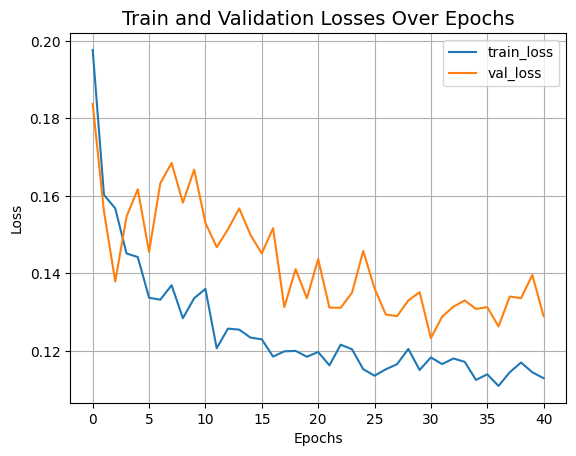

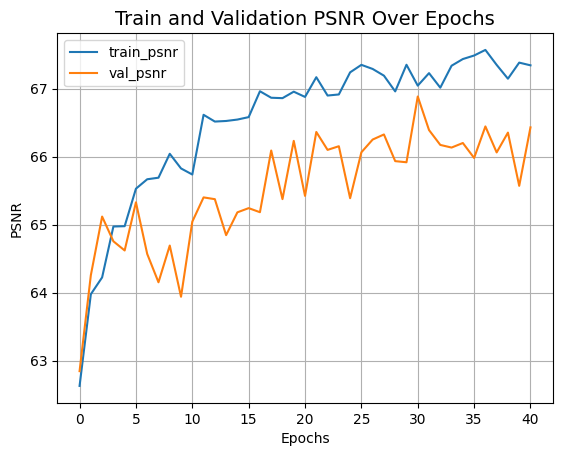

In [ ]:
import os

# Create the Results directory if it doesn't exist
if not os.path.exists('Results'):
    os.makedirs('Results')

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig("Results/loss_over_epochs"+str(num_epochs)+"_"+"Modified_MIRNET.png")
plt.show()


plt.plot(history.history["peak_signal_noise_ratio"], label="train_psnr")
plt.plot(history.history["val_peak_signal_noise_ratio"], label="val_psnr")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Train and Validation PSNR Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.savefig("Results/psnr_over_epochs"+str(num_epochs)+"_"+"Modified_MIRNET.png")
plt.show()

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step


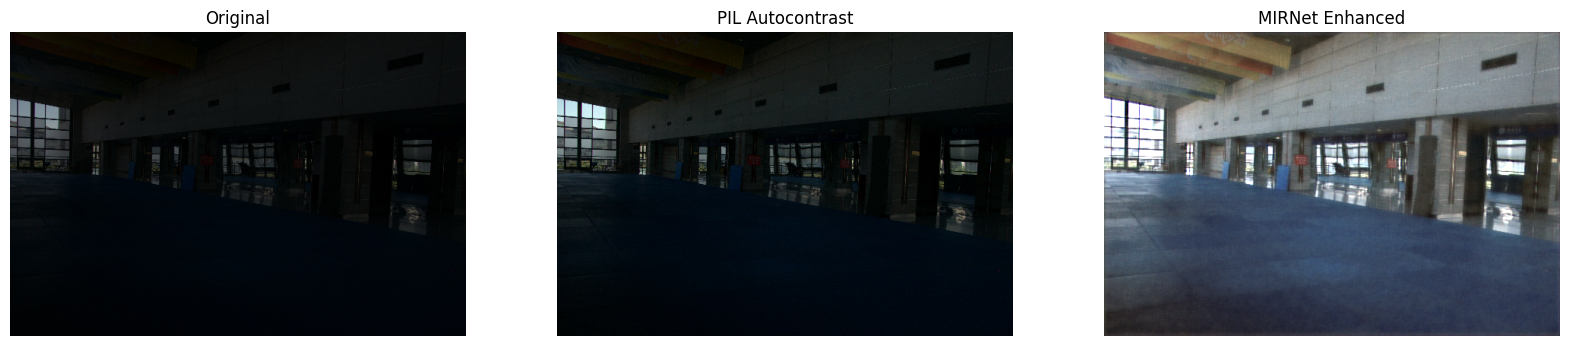

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


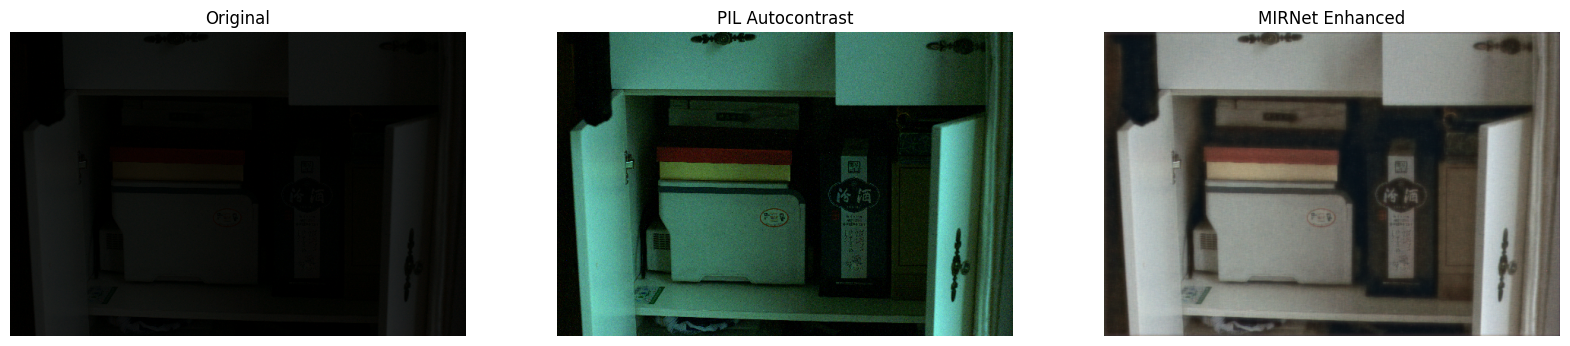

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


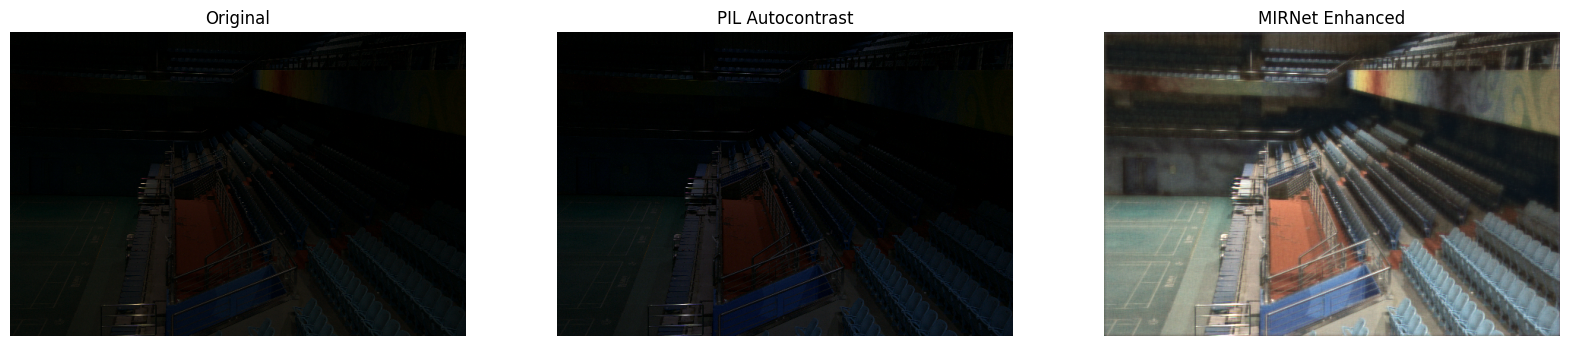

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


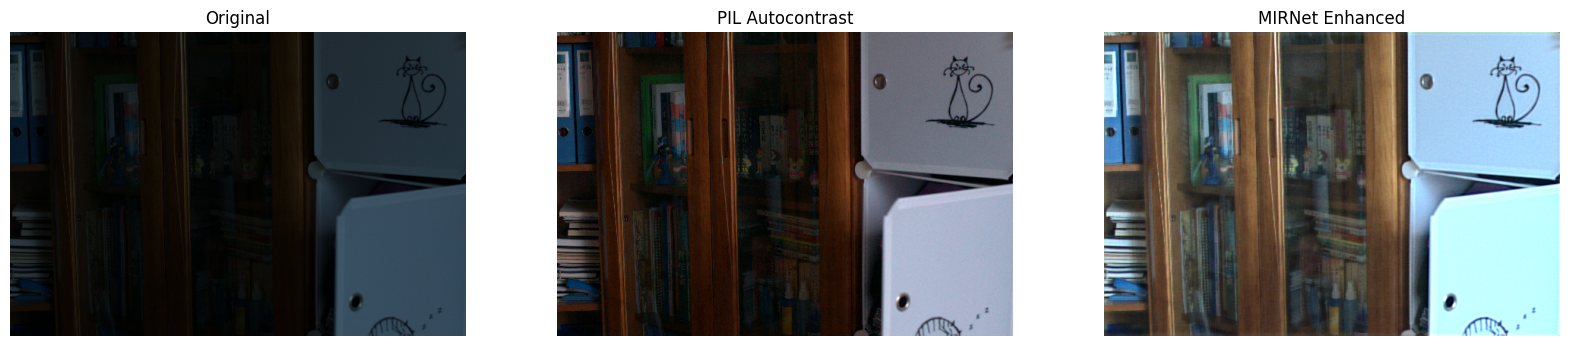

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


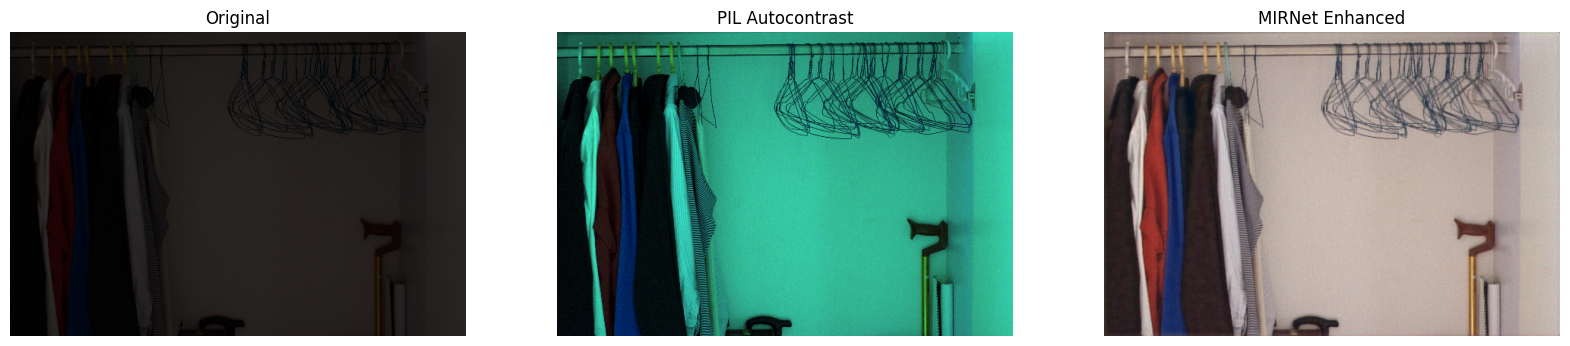

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


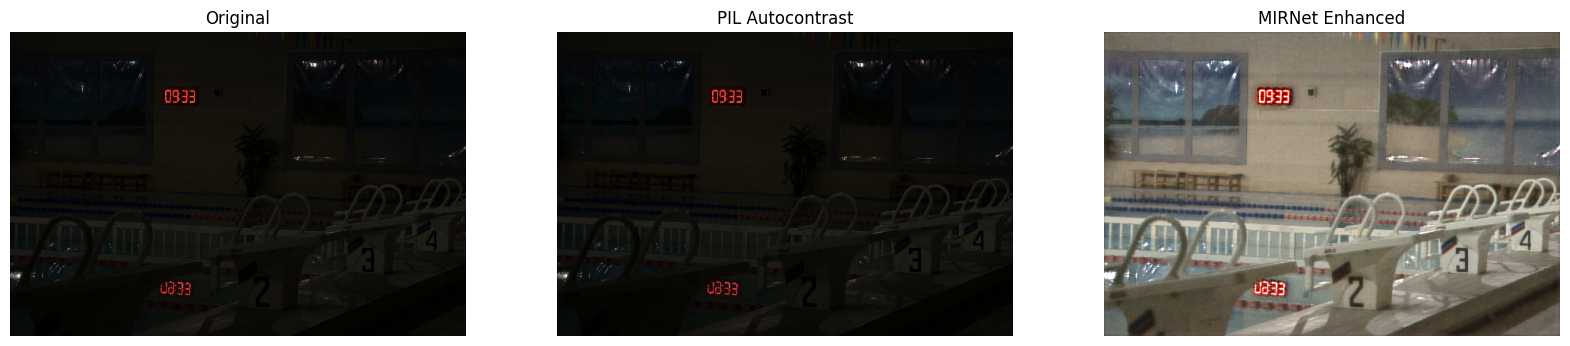

In [ ]:
for low_light_image in random.sample(test_low_light_images, 6):
    original_image = Image.open(low_light_image)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
        (20, 12),
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


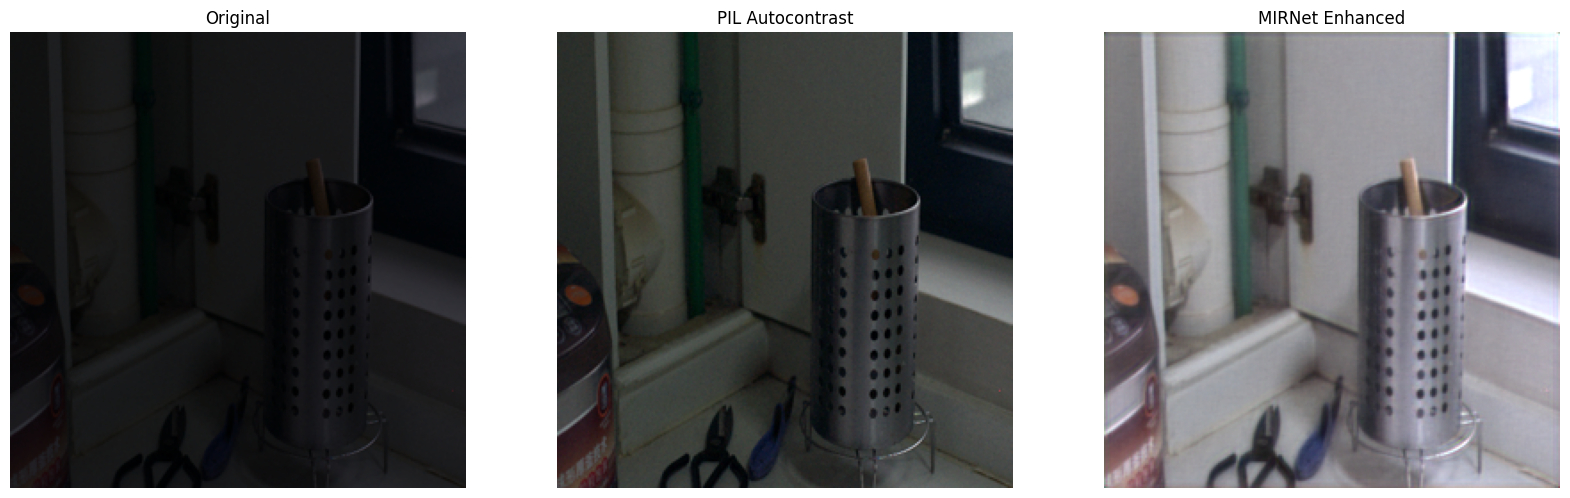

In [ ]:
# Get a random image from the test set
random_test_image_path = random.choice(test_low_light_images)
original_image = Image.open(random_test_image_path)
original_image = original_image.resize((256, 256))
enhanced_image = infer(original_image)
plot_results(
    [original_image, ImageOps.autocontrast(original_image), enhanced_image],
    ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
    (20, 12),
)